In [2]:
import xarray as xr
from datetime import datetime as dt
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy import interpolate
import warnings
warnings.filterwarnings('ignore')


In [3]:
import extract_data as data
temps = data.extractTemperature("cvl_data/455.nc")


if 'date' in temps.columns:
    temps['date'] = pd.to_datetime(temps['date'])  # Convert to datetime if not already
    temps.set_index('date', inplace=True)


In [20]:
## Divide the data into Summer and Winter using one-Hot of the two
temps_season = temps.copy (deep=True)
temps_season['month'] = temps_season.index.month
mask_winter = (temps_season['month'] >= 11) | (temps_season['month'] <= 2)
mask_summer = (temps_season['month'] >= 3) & (temps_season['month'] <= 6)
temps_season['winter'] = np.where(mask_winter, 1,0)
temps_season['summer'] = np.where(mask_summer,1,0)

# Plotting the Trends

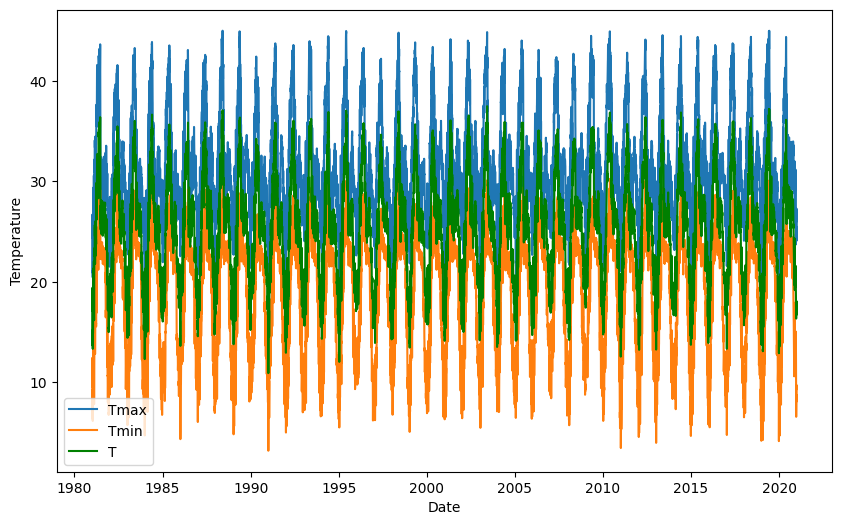

In [21]:
# The entire time series data for Tmax, Tmin, and T
plt.figure(figsize=(10, 6))
plt.plot(temps.index, temps['Tmax'], label='Tmax')
plt.plot(temps.index, temps['Tmin'], label='Tmin')
plt.plot(temps.index, temps['T'], label='T', color='green')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.legend()

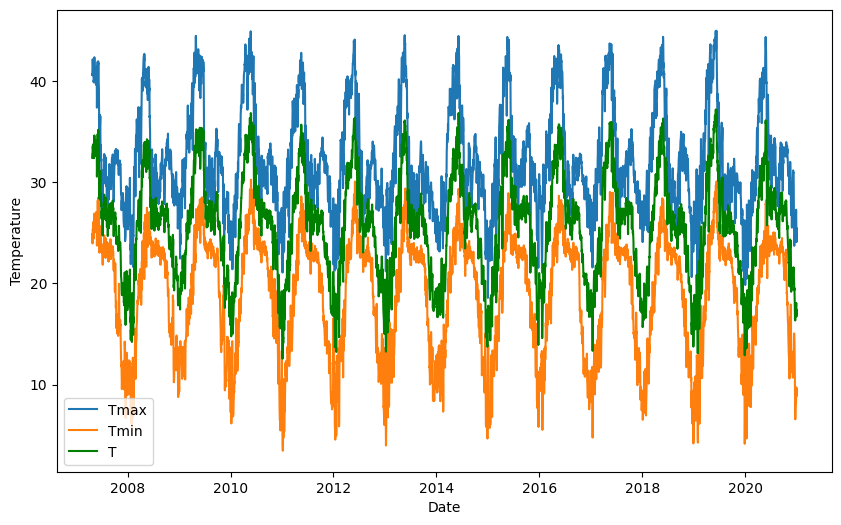

In [22]:
# #Timeseries plot - ~14 years temps [-5000: ]-plot(figsize=(8,6))
plt.figure(figsize=(10, 6))
plt.plot(temps[-5000:].index, temps[-5000:]['Tmax'], label='Tmax')
plt.plot(temps[-5000:].index, temps[-5000:]['Tmin'], label='Tmin')
plt.plot(temps[-5000:].index, temps[-5000:]['T'], label='T', color='green')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.legend()

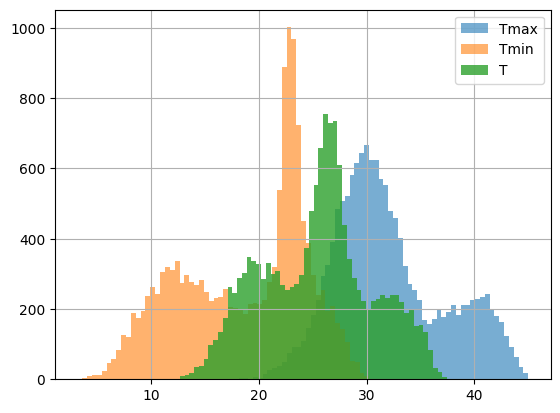

In [23]:
#Temperature distributions in histogram plt. figure(figsize=(8,6))
temps.Tmax.hist(bins=60, alpha=0.6, label='Tmax')
temps.Tmin.hist(bins=60, alpha=0.6, label='Tmin')
temps['T'].hist(bins=60, alpha=0.8, label='T')
plt.legend()

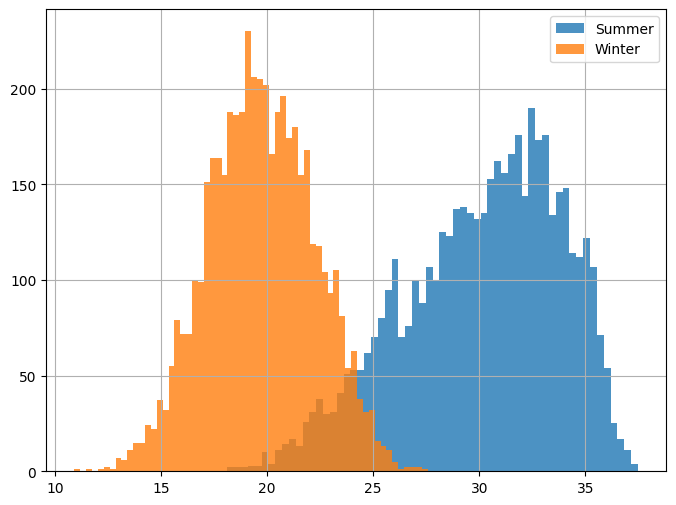

In [25]:
#Plots histograms of summer and winter temperatures.
plt.figure(figsize=(8,6))
temps_season[temps_season['summer'] == 1]['T'].hist(bins=60, alpha=0.8, label='Summer') 
temps_season[temps_season['winter'] == 1]['T'].hist(bins=60, alpha=0.8, label='Winter')
plt. legend()

# Visualisation of Trend and Seasonality

In [26]:
#Imports @-Q plot, ADFuller, Seasonal Decompose, ACF, and P-ACF tools. 
from statsmodels.graphics.api import qqplot 
from statsmodels.tsa.stattools import adfuller 
from statsmodels.tsa.seasonal import seasonal_decompose 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
from statsmodels.tsa.ar_model import AutoReg, ar_select_order, AutoRegResults

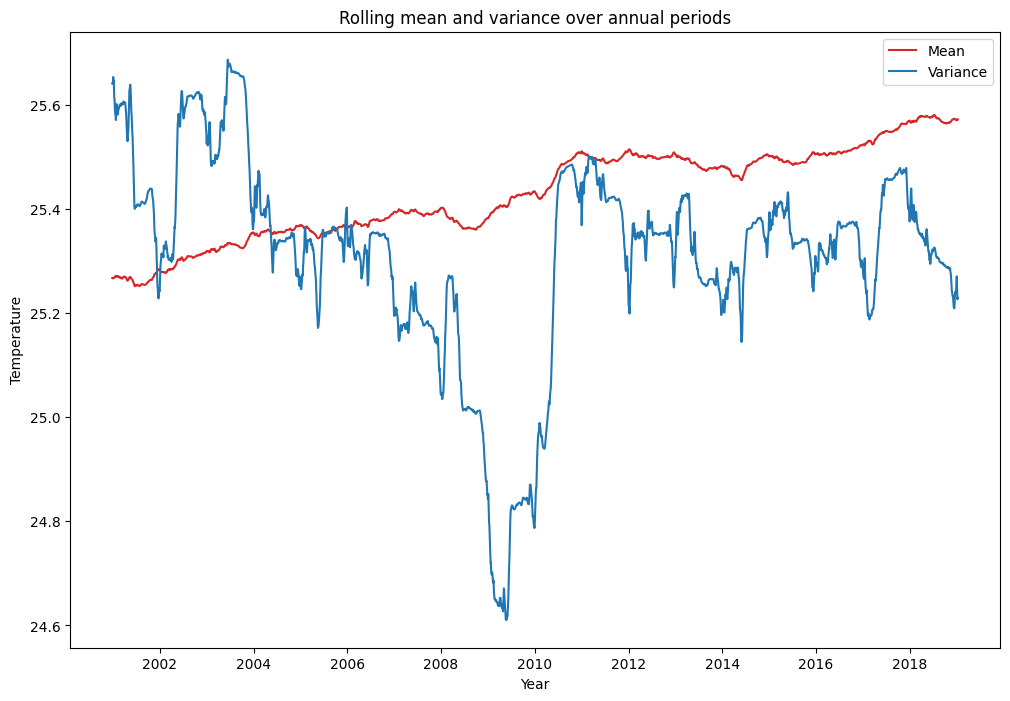

In [27]:
#Plots Rolling mean over Annual Period (Red) and RolLing Variance over Annual period (BLue).
# Set the window for the rolling calculations (365 days for annual rolling mean/variance)
Years = 20
window_size = 365 * Years

# Calculate the rolling mean and variance
rolling_mean = temps['T'].rolling(window=window_size).mean()
rolling_variance = temps['T'].rolling(window=window_size).var()

# Plotting with matplotlib
plt.figure(figsize=(12, 8))
plt.plot(temps.index, rolling_mean, color="tab:red", label='Mean')
plt.plot(temps.index, rolling_variance, color="tab:blue", label='Variance')
plt.title("Rolling mean and variance over annual periods")
plt.xlabel('Year')
plt.ylabel('Temperature')
plt.legend()
plt.show()


# Seasonal decomposition and visualization of trend, seasonality, and residuals.

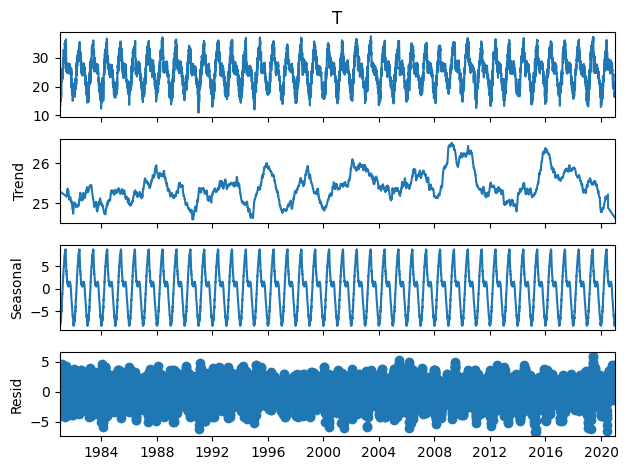

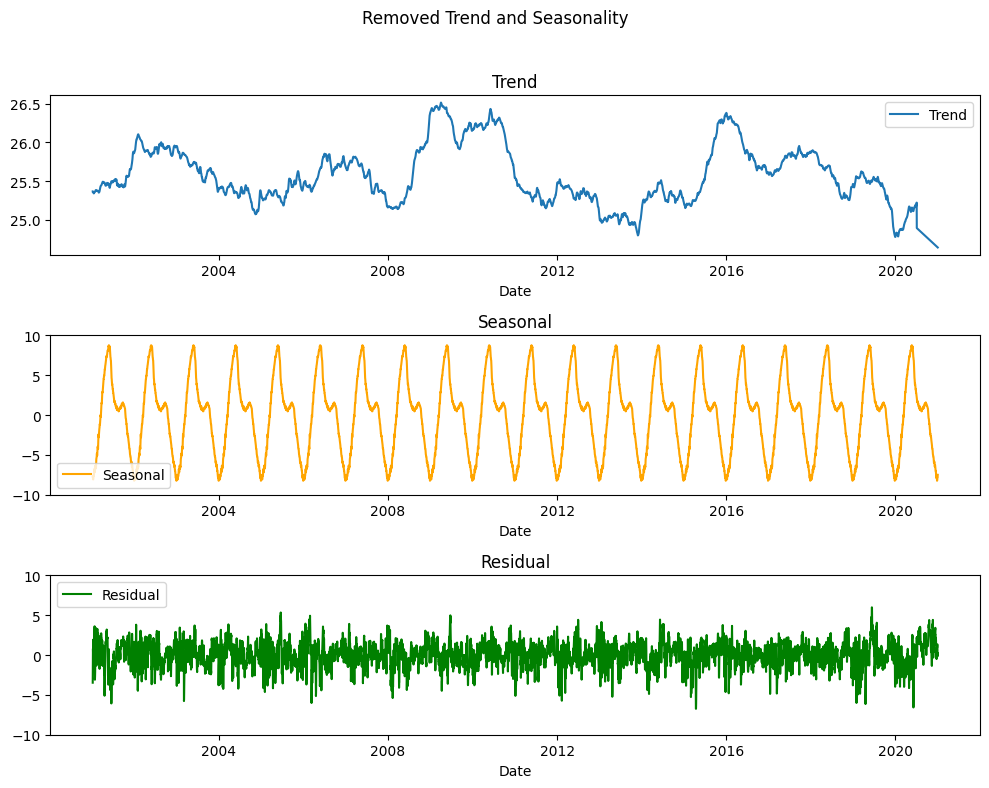

In [52]:
# Apply seasonal decomposition to time series and plot Data, Trend, Seasonal, and Residual components.
temps['T'] = temps['T'].fillna(method='ffill')

decompose_result = seasonal_decompose(temps['T'], model='additive', period=365, extrapolate_trend='freq')
trend = decompose_result.trend
seasonal = decompose_result.seasonal
residual = decompose_result.resid

# Visualize Data, Trend, Seasonal, and Residuals
decompose_result.plot()
plt.show()

# Visualize last x years
Years = 20
years_examine = 365 * Years

fig, axs = plt.subplots(3, figsize=(10, 8))
fig.suptitle('Removed Trend and Seasonality')

# Plot Trend component
axs[0].plot(trend.index[-years_examine:], trend[-years_examine:], label='Trend')
axs[0].set_title('Trend')
axs[0].legend()

# Plot Seasonal component
axs[1].plot(seasonal.index[-years_examine:], seasonal[-years_examine:], label='Seasonal', color='orange')
axs[1].set_ylim([-10, 10])
axs[1].set_title('Seasonal')
axs[1].legend()

# Plot Residual component
axs[2].plot(residual.index[-years_examine:], residual[-years_examine:], label='Residual', color='green')
axs[2].set_ylim([-10, 10])
axs[2].set_title('Residual')
axs[2].legend()

# Set x-axis labels
for ax in axs:
    ax.set_xlabel('Date')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


# Fitting models to daily average temperature time series were applied, and model parameters were obtained and compared.


         Model 1 Parameters 

a: 25.160 CI - normally [2.51e+01, 2.52e+01]
b: 0.000 CI - normally [2.51e-05, 4.60e-05]
a1: -5.785 CI - normally [-5.85e+00, -5.72e+00]
b1: 1.744 CI - normally [1.68e+00, 1.81e+00]

          Model 2 Parameters 

a: 25.160 CI -normally [2.51e+01, 2.52e+01]
b: 0.000 CI -normally [2.51e-05, 4.60e-05]
a1: -191.134 CI -normally [-9.02e+06, 9.02e+06]
b1: -192.324 CI -normally [-9.02e+06, 9.02e+06]
theta: -469.193 CI -normally [-7.32e+04, 7.23e+04]
phi: 691.657 CI -normally [-7.16e+04, 7.30e+04]

      Residual Sum of Squares (RSS) 

 RSS Model 1 (Sine): 33411.86
 RSS Model 2 (Gen): 33411.87


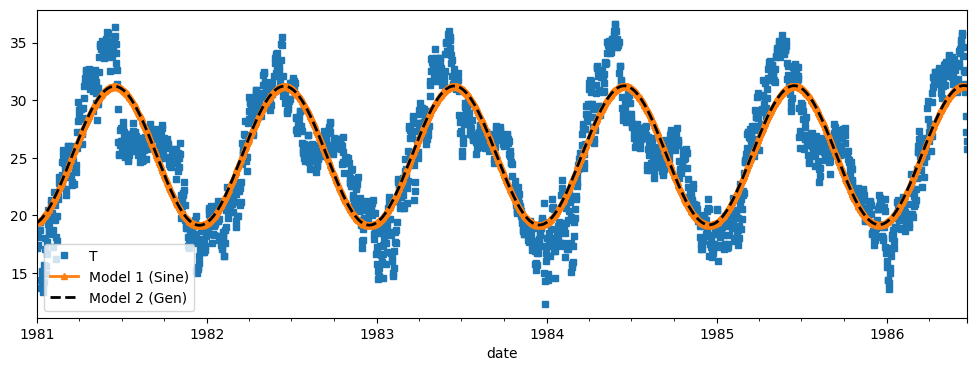

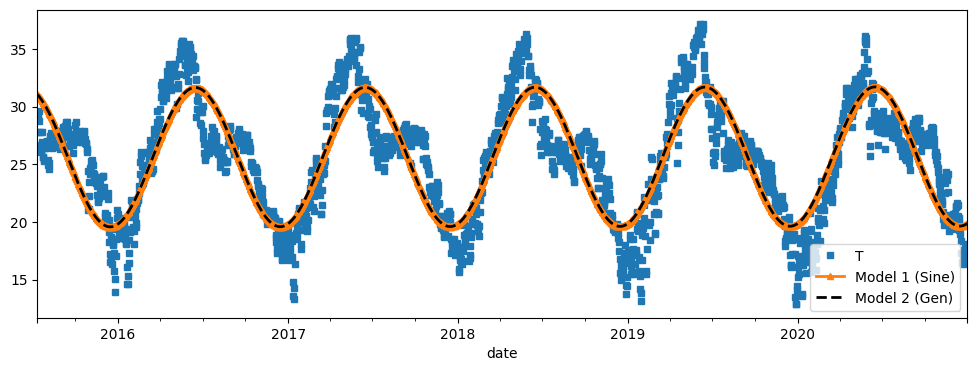

In [29]:
# Apply fitting models and calculate parameters with Residual Sum of Squares (RSS)|
# Model 1 Tt =a+bt+asin(wt+8) here y_pred = a+bt+alsin((omega)x+b1)|
# Model 2 Tt'=a+bt+asin(wt+9)+8cos(wt+ф) here y_pred = a+bt+alsin ((omegha)x+theta)+bicos ((omega)x+phi)
from scipy.stats import norm
from scipy.optimize import curve_fit
temp_t = temps['T'].copy(deep=True)
temp_t = temp_t.to_frame()

# Define Models
# Model 1（Sine）
def model_fit(x, a, b, a1, b1):
    omega = 2*np.pi/365.25
    y_pred = a + b*x + a1*np.cos(omega*x) + b1*np.sin(omega*x)
    return y_pred

def RSS(y, y_pred):
    return np.sqrt((y - y_pred)**2).sum()

# Model 2 (Generalized)
def model_fit_general(x, a, b, a1, b1, theta, phi):
    omega = 2*np.pi/365.25
    y_pred = a + b*x + a1*np.cos(omega*x + theta) + b1*np.sin(omega*x + phi)
    return y_pred

if isinstance(temp_t.index, pd.DatetimeIndex):
    first_ord = temp_t.index.map(dt.toordinal)[0]  # Corrected line
    temp_t.index = temp_t.index.map(dt.toordinal)

params, cov = curve_fit(model_fit, xdata=temp_t.index-first_ord, ydata=temp_t['T'], method='lm')  # Corrected line
param_list = ['a', 'b', 'a1', 'b1']
print('\n         Model 1 Parameters \n')
std_dev = np.sqrt(np.diag(cov))
for name, p, sd in zip(param_list, params, std_dev):
    print('{0}: {1:0.3f} CI - normally [{2:0.2e}, {3:0.2e}]'.format(name, p, p - 1.96 * sd, p + 1.96 * sd))
temp_t['Model 1 (Sine)'] = model_fit(temp_t.index-first_ord, *params)

if isinstance(temp_t.index, pd.DatetimeIndex):
    temp_t.index = temp_t.index.map(dt.toordinal)
params1, cov1 = curve_fit(model_fit_general, xdata=temp_t.index-first_ord, ydata=temp_t['T'], method='lm')  # Corrected line
param_list = ['a', 'b', 'a1', 'b1', 'theta', 'phi']

print('\n          Model 2 Parameters \n')
std_dev = np.sqrt(np.diag(cov1))
for name, p, sd in zip(param_list, params1, std_dev):
    print('{0}: {1:0.3f} CI -normally [{2:0.2e}, {3:0.2e}]'.format(name, p, p-1.96*sd, p+1.96*sd))  # Corrected line
temp_t['Model 2 (Gen)'] = model_fit_general(temp_t.index-first_ord, *params1)

if not isinstance(temp_t.index, pd.DatetimeIndex):
    temp_t.index = temp_t.index.map(dt.fromordinal)
temp_t[:2000].plot(figsize=(12, 4), style=['s', '^-', 'k--'], markersize=4, linewidth=2)
temp_t[-2000:].plot(figsize=(12, 4), style=['s', '^-', 'k--'], markersize=4, linewidth=2)
RSS(temp_t['T'], temp_t['Model 2 (Gen)'])
print('\n      Residual Sum of Squares (RSS) \n')
print(' RSS Model 1 (Sine):', round(RSS(temp_t['T'], temp_t['Model 1 (Sine)']), 2))
print(' RSS Model 2 (Gen):', round(RSS(temp_t['T'], temp_t['Model 2 (Gen)']), 2))

# Fitting Parameters were calculated and applied to fitted data.

Parameters: 
 a 25.2
 b 3.56e-05
 alpha 6.04
 theta -1.28


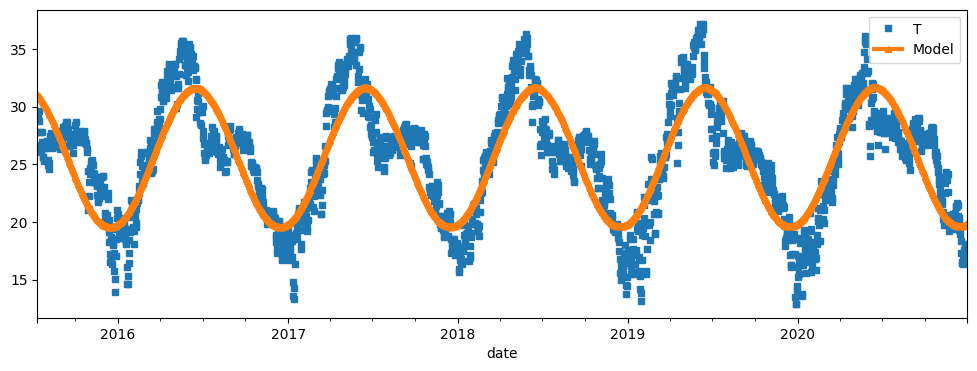

In [30]:
#Calculate parameters with data and fit curve
temp_t = temps['T'].copy(deep=True)
temp_t = temp_t.to_frame()

def model(x, params):
    a,b,a1,b1 = params
    omega = 2*np.pi/365.25
    theta = np.arctan(a1/b1)

    alpha = np.sqrt( a1**2 + b1**2)
    print('Parameters: \n a {0:0.3}\n b {1:0.3}\n alpha {2:0.3}\n theta {3:0.3}'.format (a,b,alpha, theta))
    y_pred = a + b*x + alpha*np.sin(omega*x + theta)
    return y_pred
def model_fit(x, a, b, al, b1):
    omega = 2*np.pi/365.25

    y_pred = a + b*x + al*np.cos(omega*x) + b1*np.sin(omega*x)
    return y_pred

if isinstance(temp_t.index , pd.DatetimeIndex):
    first_ord = temp_t.index.map(dt.toordinal)[0]
    temp_t.index=temp_t.index.map(dt.toordinal)

params_all, cov = curve_fit(model_fit, xdata=temp_t.index-first_ord, ydata=temp_t['T'], method='lm')  # Corrected 'data' to 'xdata'
temp_t[ 'Model'] = model(temp_t.index-first_ord, params_all)

if not isinstance(temp_t.index , pd.DatetimeIndex):
    temp_t.index=temp_t.index.map(dt.fromordinal)

temp_t[-2000:].plot(figsize=(12,4), style=['s','^-','k-'] , markersize=4, linewidth=3 )
plt. show()

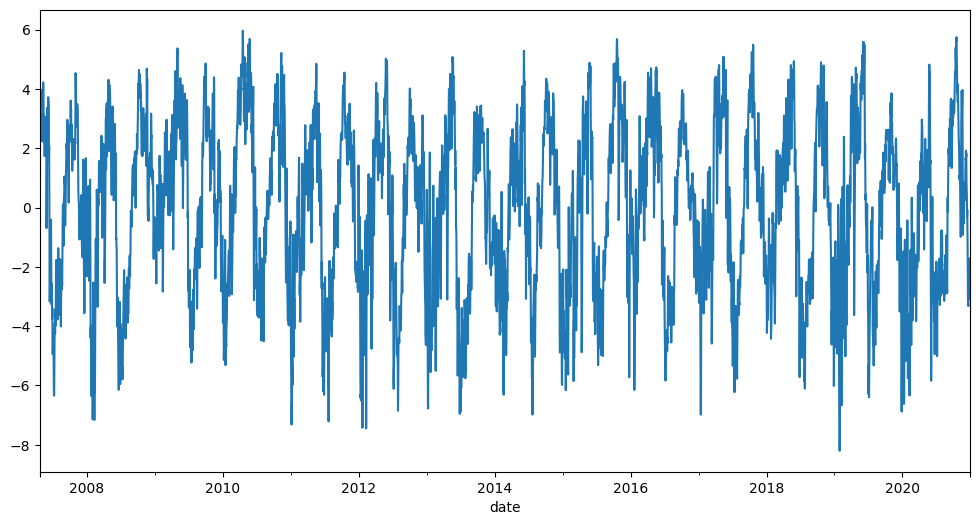

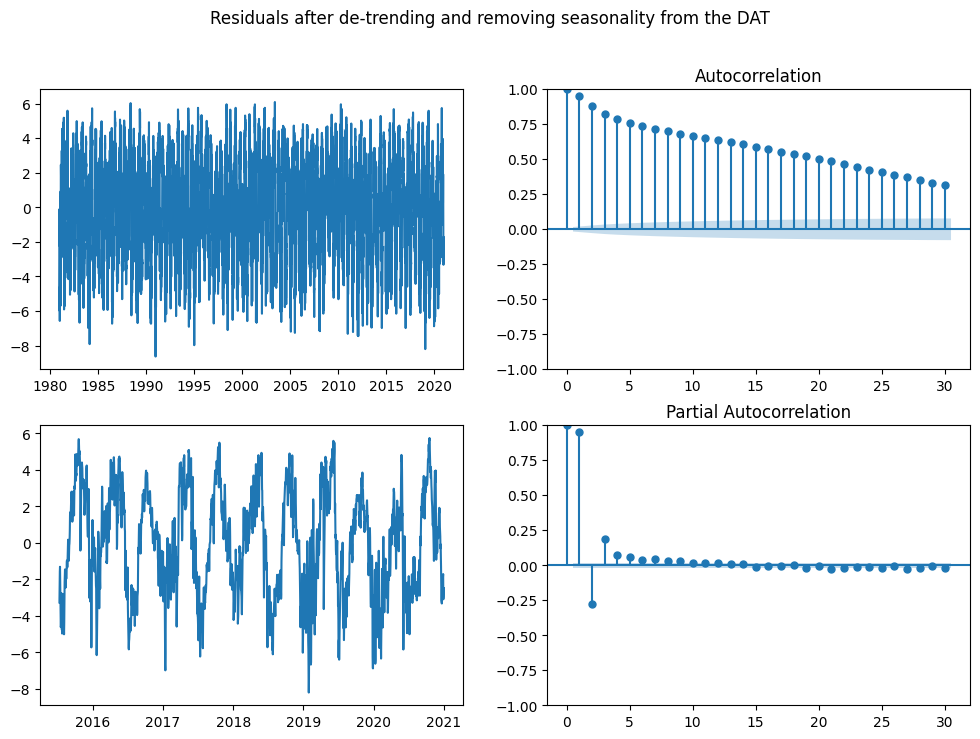

In [31]:
# Visualize Residuals after detrending and removing seasonality from the Daily Average Temperature (DAT) 12 years.
if not isinstance(temp_t.index, pd.DatetimeIndex):
    temp_t.index = temp_t.index.map(dt.datetime.fromordinal)

temp_t['res'] = temp_t['T'] - temp_t['Model']
temp_t['res'][-5000:].plot(figsize=(12, 6))
plt.show()

# Visualizes autocorrelation for all the time series (TLags) and the last few years (PLags).
TLags = 30
PLags = 30

fig, axs = plt.subplots(2, 2, figsize=(12, 8))
fig.suptitle('Residuals after de-trending and removing seasonality from the DAT')
axs[0, 0].plot(temp_t['res'])
axs[1, 0].plot(temp_t['res'][-2000:])
plot_acf(temp_t['res'], lags=TLags, ax=axs[0, 1])
plot_pacf(temp_t['res'], lags=PLags, ax=axs[1, 1])
plt.show()

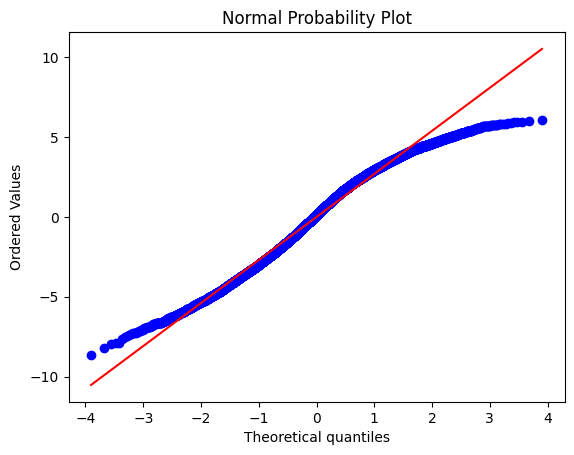

P(Z > 2): 0.335% vs. Normal Distibution: 2.28% 
Skew    : -0.192
Kurtosis: 2.24


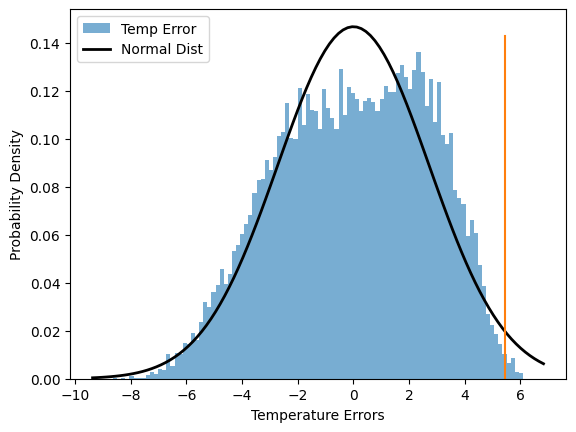

In [53]:
# Plots Probability Distribution
stats.probplot(temp_t['res'], dist="norm", plot=plt)
plt.title("Normal Probability Plot")
plt.show()

# Plot probability distribution of temperature errors and compares it to the normal distribution.
mu, std = norm.fit(temp_t['res'])
z = (temp_t['res'] - mu) / std
plt.hist(temp_t['res'], density=True, alpha=0.6, bins=100, label='Temp Error')
xmin, xmax = plt.xlim()
ymin, ymax = plt.ylim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
data = np.random.randn(100000)
plt.plot(x, p, 'k', linewidth=2, label='Normal Dist')
plt.plot([mu + std*2, mu + std*2], [0, ymax])

print('P(Z > 2): {0:0.3}% vs. Normal Distibution: {1:0.3}% '.format(len(z[z >= 2]) / len(z) * 100, (1 - norm.cdf(2)) * 100))
print('Skew    : {0:0.3}'.format(stats.skew(z)))
print('Kurtosis: {0:0.3}'.format(stats.kurtosis(z) + 3))

plt.ylabel('Probability Density')
plt.xlabel('Temperature Errors')
plt.legend()
plt.show()


# Visualisation of fitted data

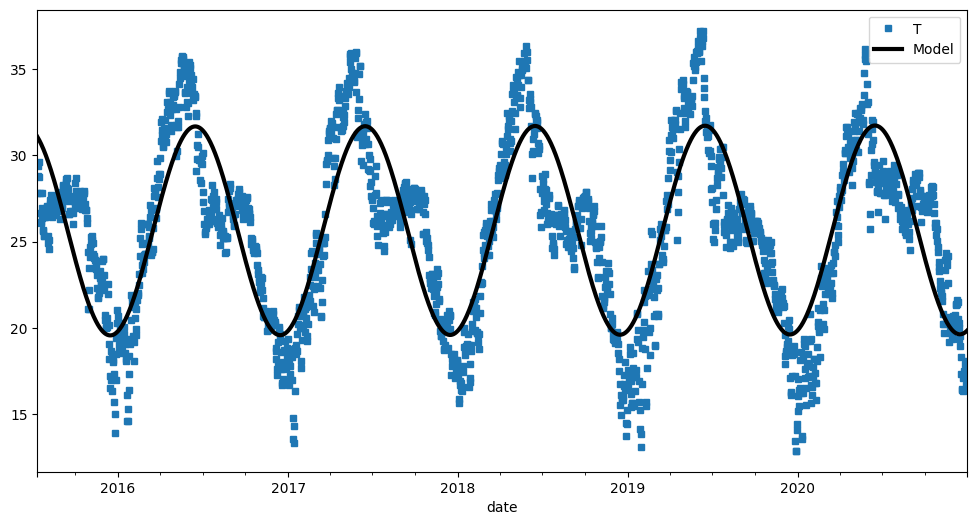

In [33]:
# Plots Partial Data and Fit Model
rows = 2000
temp_t[['T', 'Model']][-rows:].plot(figsize=(12, 6), style=['s', 'k-'], markersize=4, linewidth=3)
plt.show()

# Autoregression applied to temperature residuals

In [34]:
# Performs an Autoregression of the Residuals and prints parameters
residuals = temp_t['res']
residuals.index = pd.DatetimeIndex(residuals.index).to_period('D')
model = AutoReg(residuals, lags=1, old_names=True, trend='n')
model_fit = model.fit()
coef = model_fit.params
res = model_fit.resid
res.index = res.index.to_timestamp()
print(model_fit.summary())

                            AutoReg Model Results                             
Dep. Variable:                    res   No. Observations:                14610
Model:                     AutoReg(1)   Log Likelihood              -17898.193
Method:               Conditional MLE   S.D. of innovations              0.824
Date:                Mon, 25 Nov 2024   AIC                          35800.386
Time:                        02:53:01   BIC                          35815.564
Sample:                    01-02-1981   HQIC                         35805.428
                         - 12-31-2020                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
res.L1         0.9530      0.003    380.020      0.000       0.948       0.958
                                    Roots                                    
                  Real          Imaginary           M

# Monthly Volatality of DAT is estimated and plotted

Trend or long term volatility is approximately: ~ 1.587


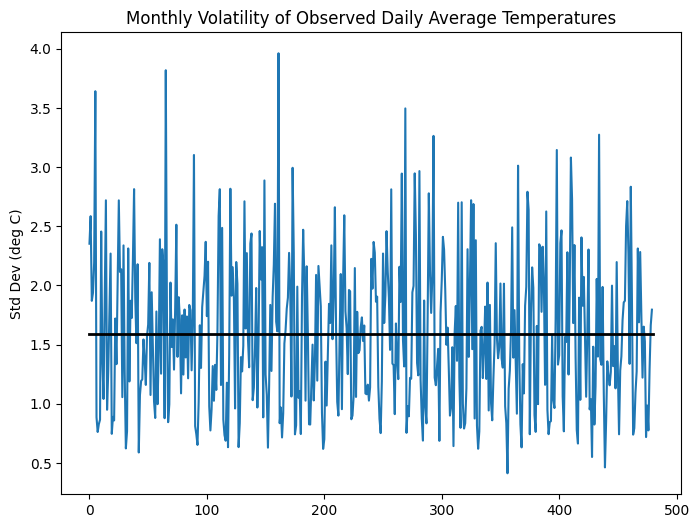

In [54]:
# Estimate volatility based on the quadratic variation of temperature process. Plot Monthly Volatility of DAT
temp_t['Day'] = temp_t.index.dayofyear
temp_t['month'] = temp_t.index.month
temp_t['year'] = temp_t.index.year

vol = temp_t.groupby(['year', 'month'])['T'].agg(['mean', 'std'])
vol = vol.reset_index()

vol['std'].plot(figsize=(8, 6))
plt.plot([0, len(vol)], [vol['std'].mean(), vol['std'].mean()], 'k', linewidth=2)
plt.ylabel('Std Dev (deg C)')
plt.title('Monthly Volatility of Observed Daily Average Temperatures')
print("Trend or long term volatility is approximately: ~", round(vol['std'].mean(), 3))
plt.show()

# Daily Volatility of DAT was estimated and plotted

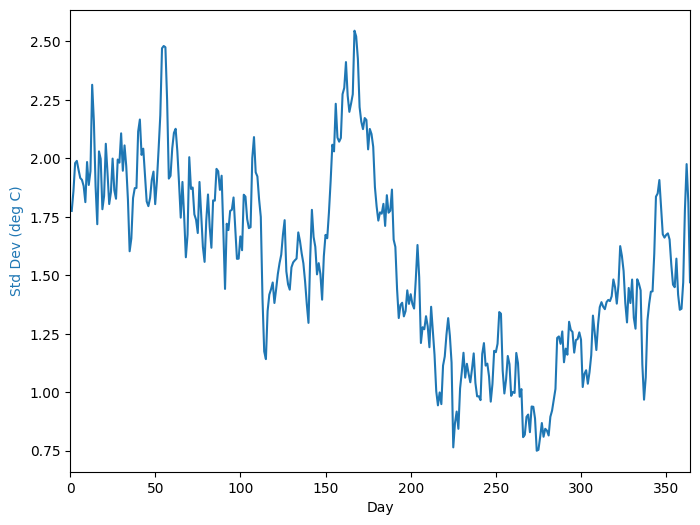

In [36]:
# Estimate Daily Volatility of DAT, and Plot
vol = temp_t.groupby(['Day'])['T'].agg(['mean', 'std'])
vol['std'].plot(color='tab:blue', figsize=(8, 6))
plt.ylabel('Std Dev (deg C)', color='tab:blue')
plt.xlim(0, 364)
plt.show()

# A 5-knot (optimal) B-splined was applied to the daily volatility. 

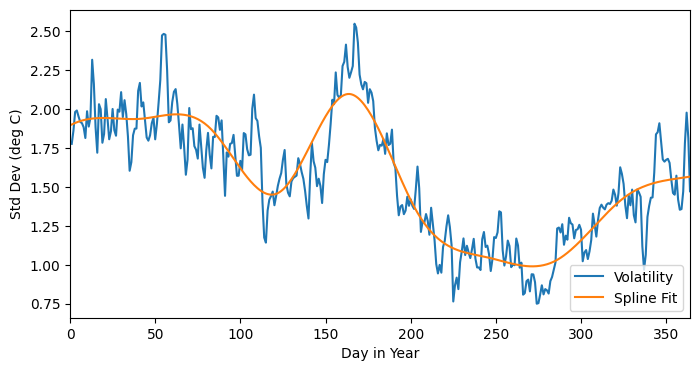

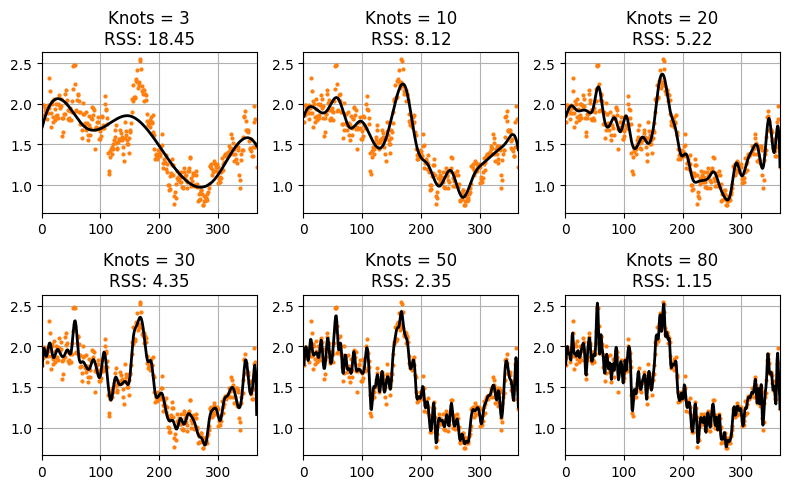

In [37]:
# Plot Spline Fit of Volatility
from scipy import interpolate
import numpy as np
import matplotlib.pyplot as plt

x = np.array(vol['std'].index)
y = np.array(vol['std'].values)
knot_numbers = 5

x_new = np.linspace(0, 1, knot_numbers*2)[1:-1]
q_knots = np.quantile(x, x_new)
t, c, k = interpolate.splrep(x, y, t=q_knots, s=1)
yfit = interpolate.BSpline(t, c, k)(x)

plt.figure(figsize=(8, 4))
plt.plot(x, y, label="Volatility")
plt.plot(x, yfit, label="Spline Fit")
plt.ylabel('Std Dev (deg C)')
plt.xlabel('Day in Year')
plt.xlim(0, 364)
plt.legend(loc='lower right')
plt.show()

# Define function for spline fitting with adjustable knots
def spline(knots, x, y):
    x_new = np.linspace(0, 1, knots*2)[1:-1]
    t, c, k = interpolate.splrep(x, y, t=np.quantile(x, x_new), s=3)
    yfit = interpolate.BSpline(t, c, k)(x)
    return yfit

knots = [3, 10, 20, 30, 50, 80]
i = 0
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(8, 5))
for row in range(2):
    for col in range(3):
        ax[row][col].plot(x, y, '.', c='tab:orange', markersize=4)
        yfit = spline(knots[i], x, y)
        rss = np.sum(np.square(y - yfit))
        ax[row][col].plot(x, yfit, 'k', linewidth=2)
        ax[row][col].set_title("Knots = " + str(knots[i]) + "\nRSS: " + str(round(rss, 2)), color='k')
        ax[row][col].set_xlim(0, 366)
        ax[row][col].grid()
        i += 1

plt.tight_layout()
plt.show()


# Volatility function was obtained from the quadratic variation of the Temperature process.

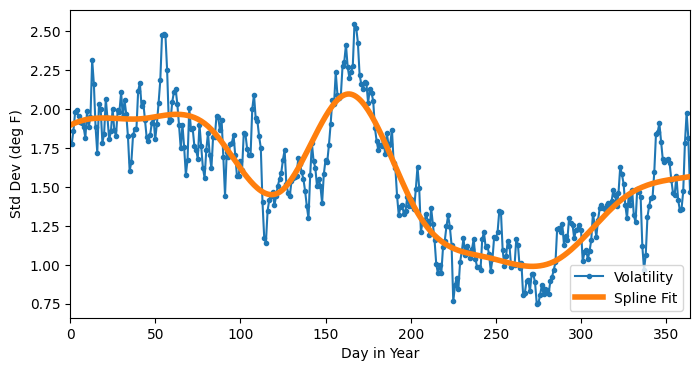

In [38]:
# Estimate Volatility from the quadratic variation of the Temperature Process
temp_vol = temps['T'].copy(deep=True)
temp_vol = temp_vol.to_frame()
temp_vol['Day'] = temp_vol.index.dayofyear
temp_vol['month'] = temp_vol.index.month

vol = temp_vol.groupby(['Day'])['T'].agg(['mean', 'std'])
days = np.array(vol['std'].index)
T_std = np.array(vol['std'].values)

# Fits Std Dev to 5-knots spline
def spline(knots, x, y):
    x_new = np.linspace(0, 1, knots*2)[1:-1]
    t, c, k = interpolate.splrep(x, y, t=np.quantile(x, x_new), s=3)
    yfit = interpolate.BSpline(t, c, k)(x)
    return yfit

volatility = spline(5, days, T_std)
plt.figure(figsize=(8, 4))
plt.plot(days, T_std, marker='.', label='Volatility')
plt.plot(days, volatility, linewidth=4, label='Spline Fit')
plt.ylabel('Std Dev (deg F)')
plt.xlabel('Day in Year')
plt.xlim(0, 364)
plt.legend(loc='lower right')
plt.show()

# The volatility ($\kappa$) of the volatility process was estimated using the quadratic variation of $\sigma$.

In [67]:
# Estimate volatility of the volatility process by using the quadratic variation of sigma.
print('Gamma is: ', round(vol['std'].std(), 3))

model = AutoReg(vol['std'], lags=1, old_names=True, trend='n')
model_fit = model.fit()
coef = model_fit.params
res = model_fit.resid

print('Rate of mean reversion of volatility process is : ', coef[0])
print(model_fit.summary())

Gamma is:  0.638
Rate of mean reversion of volatility process is :  0.8823019390649548
                            AutoReg Model Results                             
Dep. Variable:                    std   No. Observations:                  480
Model:                     AutoReg(1)   Log Likelihood                -573.941
Method:               Conditional MLE   S.D. of innovations              0.802
Date:                Mon, 25 Nov 2024   AIC                           1151.882
Time:                        03:31:43   BIC                           1160.226
Sample:                             1   HQIC                          1155.162
                                  480                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
std.L1         0.8823      0.021     41.179      0.000       0.840       0.924
                                    Roots   

# The data frame was approximated by applying an Euler-Maruyama scheme. O-U Parameters were obtained by using a Monte Carlo approximation. 

In [68]:
# Ornstein-Uhlenbeck process with Modified OU Stochastic Diff Eq. and parameters a, b, alpha, theta.
if isinstance(temp_t.index, pd.DatetimeIndex):
    first_ord = temp_t.index.map(dt.toordinal)[0]
    temp_t.index = temp_t.index.map(dt.toordinal)

# Define T
def T_model(x, a, b, alpha, theta):
    omega = 2 * np.pi / 365.25
    T = a + b * x + alpha * np.sin(omega * x + theta)
    return T

# Define dT
def dT_model(x, a, b, alpha, theta):
    omega = 2 * np.pi / 365.25
    dT = b + alpha * omega * np.cos(omega * x + theta)
    return dT

# Input parameters and plot model
Tbar_params = [25.2, 3.56e-05, 6.04, -1.28]
temp_t['model_fit'] = T_model(temp_t.index - first_ord, *Tbar_params)
if not isinstance(temp_t.index, pd.DatetimeIndex):
    temp_t.index = temp_t.index.map(dt.fromordinal)

# temp_t[['T']].plot(figsize=(12,4), style=['s', '^--', 'k-'], markersize=4, linewidth=2)

In [79]:
def euler_step(row, kappa, M):
    """
    Function for Euler scheme approximation step in
    modified OH dynamics for temperature simulations
    Inputs:
    - dataframe row with columns: T, Tbar, dTbar and vol
    - kappa: rate of mean reversion
    Output:
    - temp: simulated next day temperatures
    """
    if not pd.isna(row['T_prev']):
        T_prev = row['T_prev']
    else:
        T_prev = row['Tbar']
    # Compute the stochastic term
    stochastic_term = row['vol'] * np.random.randn(M)
    # Update temperature
    T_next = T_prev + kappa * (row['Tbar'] - T_prev) + stochastic_term
    return T_next

def monte_carlo_temp(trading_dates, Tbar_params, vol_model, first_ord, M=1, kappa=0.438):
    """
    Monte Carlo simulation of temperature
    Inputs:
    - trading_dates: pandas DatetimeIndex from start to end dates
    - M: number of simulations
    - Tbar_params: parameters used for Tbar model
    - vol_model: fitted volatility model with days in year index
    - first_ord: first ordinal of fitted Tbar model
    Outputs:
    - mc_temps: DataFrame of all components individual components
    - mc_sims: DataFrame of all simulated temperature paths
    """
    # Convert trading dates to ordinals if necessary
    if isinstance(trading_dates, pd.DatetimeIndex):
        trading_dates_ord = trading_dates.map(dt.toordinal)
    else:
        trading_dates_ord = trading_dates

    # Simulate Tbar and convert to NumPy array
    Tbars = T_model(trading_dates_ord - first_ord, *Tbar_params)
    Tbars = np.array(Tbars)

    # Prepare volatility array
    vol = vol_model[(trading_dates.dayofyear - 1).values]

    # Number of time steps
    N = len(trading_dates)

    # Initialize arrays to store simulations
    T_sim = np.zeros((N, M))  # Simulated temperatures

    # Initialize T_prev with Tbar[0] for all simulations
    T_prev = np.full(M, Tbars[0])

    # Perform the simulation over all time steps
    for i in range(N):
        stochastic_term = vol[i] * np.random.randn(M)
        T_next = T_prev + kappa * (Tbars[i] - T_prev) + stochastic_term
        T_sim[i, :] = T_next
        T_prev = T_next  # Update T_prev for next time step

    # Create DataFrame for simulations
    mc_sims = pd.DataFrame(T_sim, index=trading_dates)

    # Prepare mc_temps DataFrame
    mc_temps = pd.DataFrame({
        'Tbar': Tbars,
        'vol': vol
    }, index=trading_dates)

    return mc_temps, mc_sims

In [80]:
# Define trading date range
no_sims = 5
trading_dates = pd.date_range(start='2024-04-22', end='2025-04-22', freq='D')
mc_temps, mc_sims = monte_carlo_temp(trading_dates, Tbar_params, volatility, first_ord, no_sims)

mc_temps

,Tbar,vol
2024-04-22,29.339892,1.467492
2024-04-23,29.423119,1.461559
2024-04-24,29.505263,1.456737
2024-04-25,29.586300,1.453086
2024-04-26,29.666205,1.450665
...,...,...
2025-04-18,28.987675,1.511750
2025-04-19,29.075227,1.501151
2025-04-20,29.161802,1.491367
2025-04-21,29.247375,1.482456


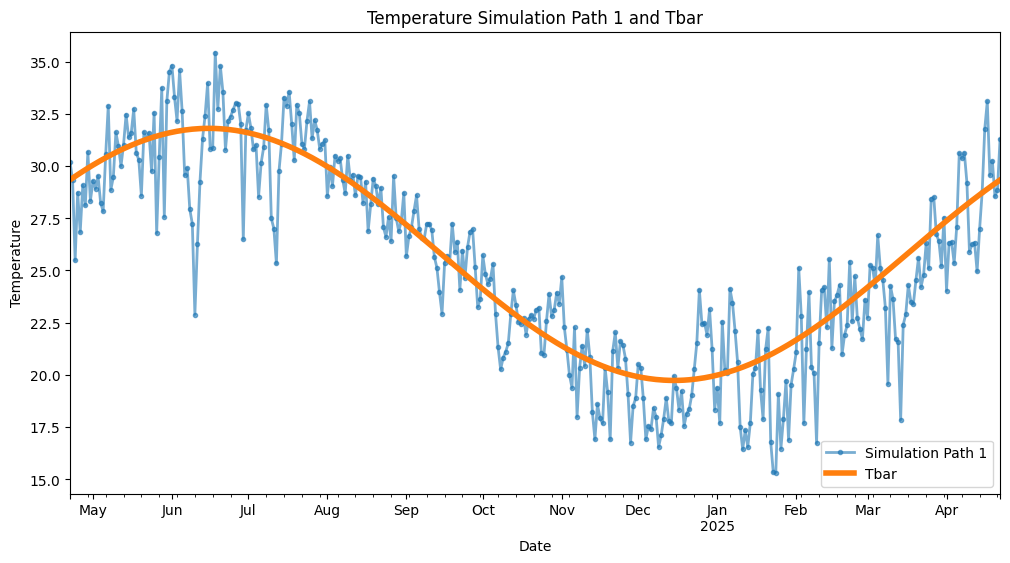

In [85]:
# Extract the first simulation path by getting the first element in each array in the first column
first_sim_path = mc_sims.iloc[:, 0]  # Assuming simulations are stored in columns

# Plotting the extracted first simulation path
plt.figure(figsize=(12, 6))
first_sim_path.plot(alpha=0.6, linewidth=2, marker='.', label='Simulation Path 1')
mc_temps["Tbar"].plot(linewidth=4, label='Tbar')
plt.legend(loc='lower right')
plt.xlabel("Date")
plt.ylabel("Temperature")
plt.title("Temperature Simulation Path 1 and Tbar")
plt.show()


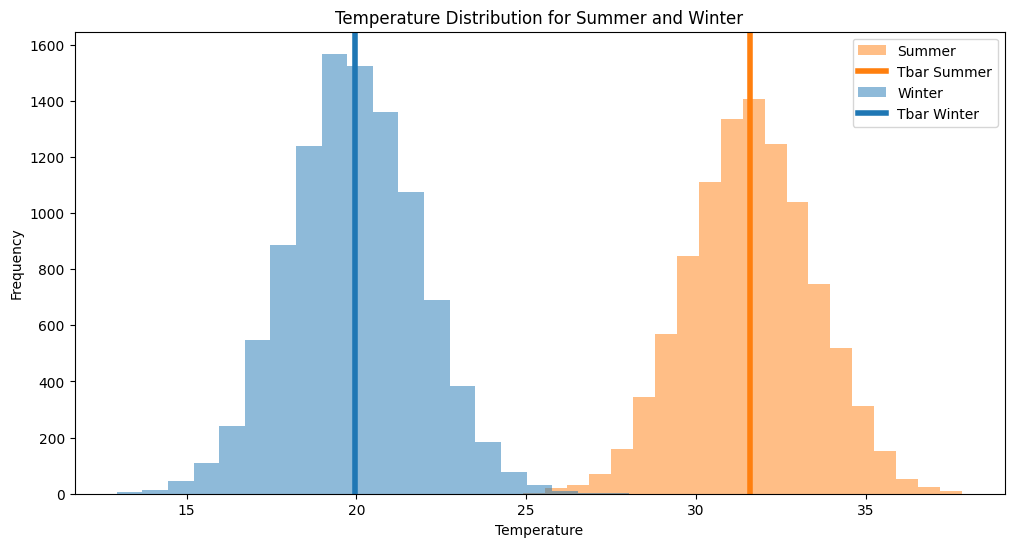

In [86]:
# %%
no_sims = 10000

# Define trading dates for winter and summer
trading_dates_summer = pd.date_range(start='2023-07-01', end='2023-07-01', freq='D')
trading_dates_winter = pd.date_range(start='2023-01-01', end='2023-01-01', freq='D')

# Generate Monte Carlo temperature data for summer and winter
mc_temps_summer, mc_sims_summer = monte_carlo_temp(
    trading_dates_summer, Tbar_params, volatility, first_ord, no_sims)
mc_temps_winter, mc_sims_winter = monte_carlo_temp(
    trading_dates_winter, Tbar_params, volatility, first_ord, no_sims)

plt.figure(figsize=(12, 6))

# Extract temperatures as flat arrays
summer_temps = mc_sims_summer.iloc[0, :].values.flatten()
winter_temps = mc_sims_winter.iloc[0, :].values.flatten()

# Plot histograms
plt.hist(summer_temps, bins=20, alpha=0.5, label='Summer', color='tab:orange')
plt.axvline(mc_temps_summer.iloc[0]['Tbar'], color='tab:orange', linewidth=4, label='Tbar Summer')

plt.hist(winter_temps, bins=20, alpha=0.5, label='Winter', color='tab:blue')
plt.axvline(mc_temps_winter.iloc[0]['Tbar'], color='tab:blue', linewidth=4, label='Tbar Winter')

plt.legend()
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.title('Temperature Distribution for Summer and Winter')
plt.show()


## The code shown below, uses the results obtained in part 5 to price the winter temperature option with the Monte Carlo simulation and the O-U model and compares it to the results obtained with the Black-Scholes Model. Code name: WDPricing

In [139]:
# Import necessary libraries
import pandas as pd
import numpy as np
from scipy.interpolate import splrep, splev, interp1d
from datetime import datetime
from scipy.stats import norm
import matplotlib.pyplot as plt

# Define the Ornstein-Uhlenbeck model functions
def T_model(x, a, b, alpha, theta):
    omega = 2 * np.pi / 365.25
    return a + b * x + alpha * np.sin(omega * x + theta)

def dT_model(x, a, b, alpha, theta):
    omega = 2 * np.pi / 365.25
    return b + alpha * omega * np.cos(omega * x + theta)

def spline(knots, x, y):
    x_new = np.linspace(0, 1, knots * 2)[1:-1]
    t, c, k = splrep(x, y, t=np.quantile(x, x_new), s=3)
    yfit = splev(x, (t, c, k))
    return yfit

print("Libraries imported and helper functions defined.")


Libraries imported and helper functions defined.


In [140]:
T_base = 18  # degrees Celsius

In [141]:
# Assuming 'temps' DataFrame is available and contains necessary data
# Adding 'Month' and 'Day' columns to the dataset
if 'Month' not in temps.columns:
    temps['Month'] = temps.index.month
if 'Day' not in temps.columns:
    temps['Day'] = temps.index.day

# Ensure Tbar_params and first_ord are defined
Tbar_params = [25.2, 3.56e-05, 6.04, -1.28]
if isinstance(temps.index, pd.DatetimeIndex):
    first_ord = temps.index.map(datetime.toordinal)[0]

# Group data by day and calculate mean and std deviation
vol = temps.groupby(['Day'])['T'].agg(['mean', 'std'])
days = np.array(vol.index)
T_std = np.array(vol['std'].values)

# Spline fit for volatility
volatility = spline(5, days, T_std)
vol_model_func = interp1d(days, volatility, kind='cubic', fill_value="extrapolate")

print("Data preprocessed and volatility model created.")


Data preprocessed and volatility model created.


In [163]:
kappa = 0.638
kappa_daily = kappa / 365.25
dt = 1  # Time increment in days

In [178]:
# Define the 'euler_step' function
def euler_step(T_prev, Tbar, vol, kappa_daily, M, landa):
    dt = 1  # Time increment in days
    # Drift term
    drift = (kappa_daily * (Tbar - T_prev) - landa * vol) * dt
    # Diffusion term
    diffusion = vol * np.sqrt(dt) * np.random.randn(M)
    # Update temperature
    T_next = T_prev + drift + diffusion
    return T_next

def monte_carlo_temp(trading_dates, Tbar_params, vol_model, first_ord, M=1, T_base=18, landa=0, kappa=0.438):
    kappa_daily = kappa / 365.25  # Convert kappa to per day units
    trading_dates_ord = trading_dates.map(datetime.toordinal)
    x_values = trading_dates_ord - first_ord
    Tbars = T_model(x_values, *Tbar_params)
    mc_temps = pd.DataFrame({'Tbar': Tbars}, index=trading_dates)
    mc_temps['Day'] = mc_temps.index.dayofyear
    mc_temps['vol'] = mc_temps['Day'].apply(vol_model)
    N = len(trading_dates)
    T_sim = np.zeros((N, M))
    T_prev = np.full(M, mc_temps['Tbar'].iloc[0])
    for i in range(N):
        Tbar = mc_temps['Tbar'].iloc[i]
        vol = mc_temps['vol'].iloc[i]
        T_next = euler_step(T_prev, Tbar, vol, kappa_daily, M, landa)
        T_sim[i] = T_next
        T_prev = T_next
    # Calculate HDDs
    HDD_sim = np.maximum(0, T_base - T_sim)
    cumulative_HDD = np.sum(HDD_sim, axis=0)
    # Create DataFrames
    mc_sims = pd.DataFrame(T_sim, index=trading_dates, columns=[f'Sim_{i+1}' for i in range(M)])
    mc_HDDs = pd.DataFrame({'Cumulative_HDD': cumulative_HDD})
    return mc_temps, mc_sims, mc_HDDs

print("Monte Carlo simulation functions defined.")


Monte Carlo simulation functions defined.


In [179]:
# Define functions for risk-neutral mean and variance
def rn_mean(time_arr, vol_arr, Tbars, lamda, kappa, T_base=18):
    dt = 1/365.25
    N = len(time_arr)
    mean_intervals = -vol_arr * (1 - np.exp(-kappa * dt)) / kappa
    expected_T = np.sum(Tbars) - lamda * np.sum(mean_intervals)
    mu_rn = T_base * N - expected_T
    return mu_rn

def rn_var(time_arr, vol_arr, kappa):
    dt = 1/365.25
    var_arr = np.power(vol_arr, 2)
    var_intervals = var_arr / (2 * kappa) * (1 - np.exp(-2 * kappa * dt))
    cov_sum = 0
    for i, ti in enumerate(time_arr):
        for j, tj in enumerate(time_arr):
            if j > i:
                cov_sum += np.exp(-kappa * (tj - ti)) * var_intervals[i]
    var_rn = np.sum(var_intervals) + 2 * cov_sum
    return var_rn

print("Risk-neutral mean and variance functions defined.")


Risk-neutral mean and variance functions defined.


In [180]:
# Define the volatility model function
def vol_model(day):
    # day should be in the range 1 to 365
    return vol_model_func(day % 365)

# Define the 'risk_neutral' function
def risk_neutral(trading_dates, Tbar_params, vol_model, first_ord, landa, T_base=18, kappa=0.638):
    trading_dates_ord = trading_dates.map(datetime.toordinal)
    x_values = trading_dates_ord - first_ord

    Tbars = T_model(x_values, *Tbar_params)
    dTbars = dT_model(x_values, *Tbar_params)

    mc_temps = pd.DataFrame({'Tbar': Tbars, 'dTbar': dTbars}, index=trading_dates)
    mc_temps['Day'] = mc_temps.index.dayofyear
    mc_temps['vol'] = mc_temps['Day'].apply(vol_model)

    time_arr = np.arange(1, len(trading_dates) + 1) / 365.25
    vol_arr = mc_temps['vol'].values

    mu_rn = rn_mean(time_arr, vol_arr, Tbars, landa, kappa, T_base=T_base)
    var_rn = rn_var(time_arr, vol_arr, kappa)
    return mu_rn, var_rn

print("Volatility model and risk-neutral functions are ready.")

Volatility model and risk-neutral functions are ready.


In [181]:
# Corrected 'winter_option' function
def winter_option(trading_dates, r, alpha, K, tau, opt="c", landa=0, T_base=18):
    mu_rn, var_rn = risk_neutral(trading_dates, Tbar_params, vol_model, first_ord, landa, T_base=T_base)
    disc = np.exp(-r * tau)
    vol_rn = np.sqrt(var_rn)
    zt = (K - mu_rn) / vol_rn
    if opt.lower() == "c":
        option_value = alpha * disc * ((mu_rn - K) * norm.cdf(-zt) + vol_rn * norm.pdf(zt))
    else:
        option_value = alpha * disc * ((K - mu_rn) * norm.cdf(zt) + vol_rn * norm.pdf(zt))
    return option_value


# Define trading dates for the winter option
start_date = datetime(2023, 12, 1)
end_date = datetime(2024, 2, 28)
trading_dates = pd.date_range(start=start_date, end=end_date, freq='D')

# Set parameters
r = 0.05
alpha = 6.04
K = 20
tau = (end_date - start_date).days / 365.25
landa = 0.1

option_value = winter_option(trading_dates, r, alpha, K, tau, opt="c", landa=landa)
print(f"Winter Option Value: {option_value}")


Winter Option Value: 775129.3184030011


In [182]:
# Function for temperature option pricing
def temperature_option(trading_dates, no_sims, Tbar_params, vol_model, r, alpha, K, tau, first_ord, T_base=18, landa=0, opt="c"):
    # Run Monte Carlo simulation
    mc_temps, mc_sims, mc_HDDs = monte_carlo_temp(trading_dates, Tbar_params, vol_model, first_ord, M=no_sims, T_base=T_base, landa=landa)

    # Get cumulative HDDs
    cumulative_HDD = mc_HDDs['Cumulative_HDD'].values

    # Calculate the payoff for each simulation
    if opt.lower() == 'c':
        # For call option on HDDs
        CT = alpha * np.maximum(cumulative_HDD - K, 0)
    else:
        # For put option on HDDs
        CT = alpha * np.maximum(K - cumulative_HDD, 0)

    # Discounted expected payoff
    C0 = np.exp(-r * tau) * np.mean(CT)
    sigma = np.std(np.exp(-r * tau) * CT)
    SE = sigma / np.sqrt(no_sims)

    return C0, SE


print("Temperature option simulation function defined.")


Temperature option simulation function defined.


In [183]:
# Pricing Call and Put options using the same parameters
no_sims = 10000  # Number of simulations

call_price, call_se = temperature_option(trading_dates, no_sims, Tbar_params, vol_model, r, alpha, K, tau, first_ord, landa=landa, opt="c")
put_price, put_se = temperature_option(trading_dates, no_sims, Tbar_params, vol_model, r, alpha, K, tau, first_ord, landa=landa, opt="p")

print("Call Price: {:.2f} +/- {:.2f} (2SE)".format(call_price, call_se * 2))
print("Put Price : {:.2f} +/- {:.2f} (2SE)".format(put_price, put_se * 2))


Call Price: 169906584.59 +/- 3359918.81 (2SE)
Put Price : 5.53 +/- 0.50 (2SE)


In [215]:
# Compare Black-Scholes with MC Simulations
strikes = np.arange(4000000, 40000000, 100000)
data = np.zeros((len(strikes), 4))

for i, strike in enumerate(strikes):
    # Monte Carlo Call Option Price
    mc_call_price, _ = temperature_option(trading_dates, no_sims, Tbar_params, vol_model, r, alpha, strike, tau, first_ord, landa=landa, opt="c")
    data[i, 0] = mc_call_price
    # Black-Scholes Analogue Call Option Price
    bs_call_price = winter_option(trading_dates, r, alpha, strike, tau, opt="c", landa=landa)
    data[i, 1] = bs_call_price
    # Monte Carlo Put Option Price
    mc_put_price, _ = temperature_option(trading_dates, no_sims, Tbar_params, vol_model, r, alpha, strike, tau, first_ord, landa=landa, opt="p")
    data[i, 2] = mc_put_price
    # Black-Scholes Analogue Put Option Price
    bs_put_price = winter_option(trading_dates, r, alpha, strike, tau, opt="p", landa=landa)
    data[i, 3] = bs_put_price

# data[:, 0] /= 200
# data[:, 2] *= 10000
data = data/100
df = pd.DataFrame(data, columns=["MC Call", "BSA Call", "MC Put", "BSA Put"], index=strikes)
print(df.head())


              MC Call      BSA Call        MC Put        BSA Put
4000000  1.505553e+06  6.527096e-32  49706.855749  238643.292390
4100000  1.498775e+06  1.344733e-33  52729.355197  244610.150898
4200000  1.479886e+06  2.523044e-35  55351.185039  250577.009407
4300000  1.490782e+06  4.310862e-37  59043.386984  256543.867915
4400000  1.497279e+06  6.707082e-39  56992.221393  262510.726424


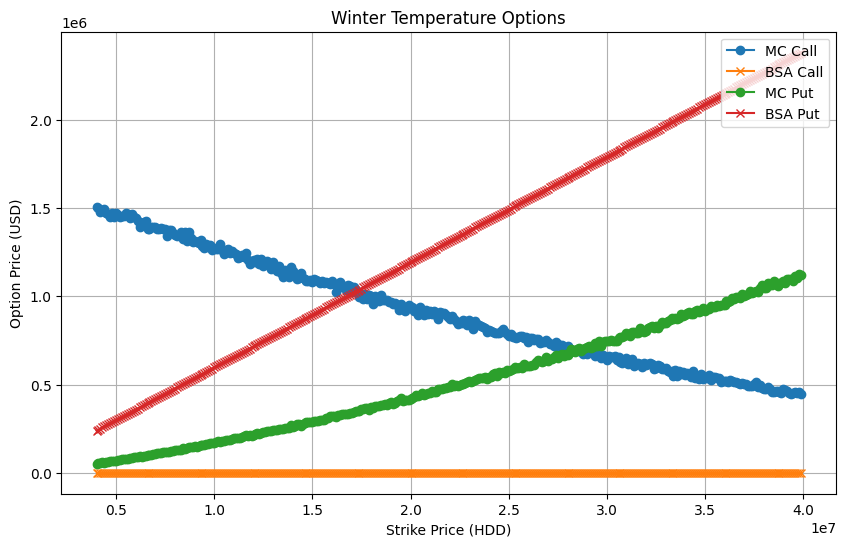

Option pricing plot displayed.


In [226]:
# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(df.index, df["MC Call"], label="MC Call", marker='o')
plt.plot(df.index, df["BSA Call"], label="BSA Call", marker='x')
plt.plot(df.index, df["MC Put"], label="MC Put", marker='o')
plt.plot(df.index, df["BSA Put"], label="BSA Put", marker='x')
plt.title("Winter Temperature Options")
plt.ylabel("Option Price (USD)")
plt.xlabel("Strike Price (HDD)")
plt.legend(loc="upper right")
plt.grid(True)
plt.show()

print("Option pricing plot displayed.")


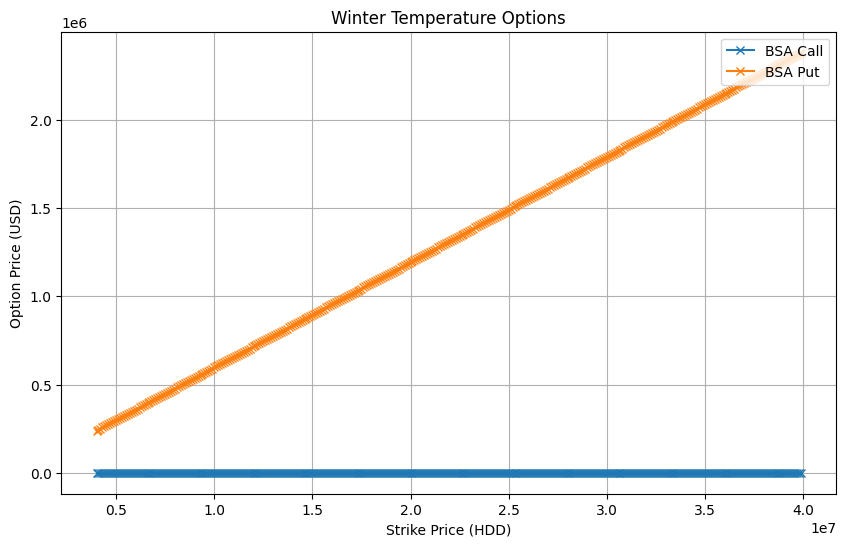

Option pricing plot displayed.


In [225]:
# Plot the results
plt.figure(figsize=(10, 6))
# plt.plot(df.index, df["MC Call"], label="MC Call", marker='o')
plt.plot(df.index, df["BSA Call"], label="BSA Call", marker='x')
# plt.plot(df.index, df["MC Put"], label="MC Put", marker='o')
plt.plot(df.index, df["BSA Put"], label="BSA Put", marker='x')
plt.title("Winter Temperature Options")
plt.ylabel("Option Price (USD)")
plt.xlabel("Strike Price (HDD)")
plt.legend(loc="upper right")
plt.grid(True)
plt.show()

print("Option pricing plot displayed.")
